In [1]:
from gwpy.timeseries import TimeSeries
from pycbc.waveform import get_td_waveform

import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

## Functions to generate 1. spectrogram with given parameters and fftlength, 2. find local maxima in an array, 3. normalize Pn curve

In [2]:
def genSpectrogram(e0, m1, m2, fftlen):
    
    hp, hc = get_td_waveform(approximant="EccentricTD",
                         mass1=m1,
                         mass2=m1,
                         delta_t=1.0/4096,
                         eccentricity=e0,
                         f_lower=20)

    h = TimeSeries(hp+hc, times=hp.sample_times)   # is it okay to just add the two????
    
    specgram = h.spectrogram(fftlen, fftlength=fftlen, overlap=fftlen/2.0) ** (1/2.0)
    
    return specgram

In [3]:
def plotSpectrogram(specgram, e0, m1, m2): 
    plot = specgram.plot()
    ax = plot.gca()
    ax.set_ylim(5, 100)
    #ax.set_yscale('log')
    ax.set_title(r'$e_0$ = {}, $m_1$ = {}, $m_2$ = {} $M_\odot$'.format(e0,m1,m2))
    plot.add_colorbar(label='GW strain PSD')
    plot.show()

In [4]:
# Function to find local maxima in an array
def localMax(y,x):

    max_y = []
    max_x = []

    for i in range(1,len(y)-1):
    
        y_val = y[i]
        x_val = x[i]
    
        if y_val >y[i-1] and y_val > y[i+1]: 
            max_y.append(y_val.value)
            max_x.append(x_val.value)

    #print "Local max y values:", max_y
    #print "Corresponding x values:", max_x
    
    return max_y, max_x

In [5]:
def genPnDist(max_asd, max_freqs, m1, m2, fftlen):
    
    # Noneccentric spectrogram 
    noneccspec = genSpectrogram(1e-10, m1, m2, fftlen)
    noneccasdbin1 = noneccspec[0]
    #norm = max(noneccasdbin1).value*(20**2)
    norm = max(noneccasdbin1).value
    
    # Normalizing -> Pn curve
    Pn = []
    n = []

    i = 1                          
    for f,asd_val in enumerate(max_asd): 
        n.append(i)
        #Pn.append(max_freqs[f]**2*asd_val/norm) 
        Pn.append(asd_val/norm) 
        i = i + 1
        
    return Pn, n

## Trying another way to find Pn values - integration

In [6]:
# Function to find local minima in an array
def localMin(y,x):

    min_y = []
    min_x = []
    min_idx = []

    for i in range(1,len(y)-1):
    
        y_val = y[i]
        x_val = x[i]
    
        if y_val < y[i-1] and y_val < y[i+1]: 
            min_y.append(y_val.value)
            min_x.append(x_val.value)
            min_idx.append(i)

    #print "Local max y values:", max_y
    #print "Corresponding x values:", max_x
    
    return min_y, min_x, min_idx

In [7]:
def genPnDistByIntegration(asd, min_idx, min_freqs, m1, m2, fftlen):
    
    # Noneccentric spectrogram 
    noneccspec = genSpectrogram(1e-10, m1, m2, fftlen)**2
    noneccasdbin1 = noneccspec[0]
    #norm = max(noneccasdbin1).value*(20**2)
    norm = max(noneccasdbin1).value
    print "norm:",norm
    
    # Normalizing -> Pn curve
    Pn = []
    n = []
    
    for i,idx in enumerate(min_idx[:-1]):
        idx2 = min_idx[i+1]
        total = np.sum(asd[idx:idx2].value)
        #power = total/((min_freqs[i+1]-min_freqs[i])*norm) 
        #power = (total/norm)/(((min_freqs[i+1]+min_freqs[i])/2)**2)
        power = total/norm
        Pn.append(power)
        n.append(i+1)
            
    return Pn, n

## Generating and Plotting Data

In [8]:
# Function to generate + plot spectrogram, hone in on first bin, and plot Pn curve 

def genSpecAndPn(e0, m1, m2, fftlen):
    
    # Generate spectrogram
    specgram = genSpectrogram(e0, m1, m2, fftlen)**2
    
    # Plot spectrogram
    plotSpectrogram(specgram, e0, m1)
    
    # Looking at first bin of spectogram
    asdbin1 = specgram[0]
    freqs = specgram.frequencies 
    
    plt.figure(figsize=(20,7))
    plt.subplot(1,2,1)
    plt.plot(freqs,asdbin1)
    plt.xlim(0,100)
    plt.title(r'First Bin for $e_0$ = {}, $m_1$ = $m_2$ = {} $M_\odot$'.format(e0,m1))
    plt.xlabel("Frequency (Hz)")
    plt.ylabel(r"ASD ($\frac{1}{\sqrt{Hz}}$)")
    
    # Finding local maxima
    max_asd, max_freqs = localMax(asdbin1, freqs)
    min_asd, min_freqs, min_idx = localMin(asdbin1, freqs)
    
    # Pn curve
    #Pn, n = genPnDist(max_asd, max_freqs, m1, m2, fftlen)
    Pn, n = genPnDistByIntegration(asdbin1, min_idx, min_freqs, m1, m2, fftlen)
    
    print "max freqs:", max_freqs
    print "min freqs:", min_freqs
    print "Pn vals:", Pn
    
    # Plotting Pn curve
    plt.subplot(1,2,2)
    plt.plot(n, Pn, 'bo')
    plt.xlim(0,16)
    plt.title(r'$P_n$ Distribution for $e_0$ = {}, $m_1$ = $m_2$ = {} $M_\odot$'.format(e0,m1))
    plt.xlabel(r"$n$ (Harmonic)")
    plt.ylabel(r"Normalized Power $P_n$")

/home/pycbc/pycbc-software/lib/python2.7/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


norm: 3.20822269153e-42
max freqs: [10.0, 20.0, 30.0, 39.0, 49.0, 59.0, 68.0, 78.0, 88.0, 97.0, 107.0, 117.0, 126.0, 136.0, 146.0, 155.0, 165.0, 175.0, 184.0, 194.0, 204.0, 214.0, 217.0, 222.0, 233.0, 236.0, 241.0, 244.0, 251.0, 253.0, 255.0, 262.0, 264.0, 272.0]
min freqs: [3.0, 15.0, 25.0, 35.0, 45.0, 54.0, 64.0, 74.0, 83.0, 93.0, 103.0, 112.0, 122.0, 132.0, 142.0, 152.0, 161.0, 171.0, 182.0, 191.0, 201.0, 211.0, 215.0, 221.0, 230.0, 235.0, 240.0, 243.0, 250.0, 252.0, 254.0, 261.0, 263.0, 271.0]
Pn vals: [0.11394845597357832, 0.79855882388404076, 0.47887258833301455, 0.1570730702327798, 0.041246783696460419, 0.0096501266792206174, 0.0021037537760444703, 0.00043727088607399512, 8.7813660054527956e-05, 1.7181310009790019e-05, 3.2938286408224599e-06, 6.2117688742897771e-07, 1.1556630990050709e-07, 2.1257965393500206e-08, 3.873000879219201e-09, 6.9976104951502421e-10, 1.2556151723777107e-10, 2.2418459600357628e-11, 3.9968250661786826e-12, 7.2341023541423155e-13, 1.3995973181227667e-13, 2

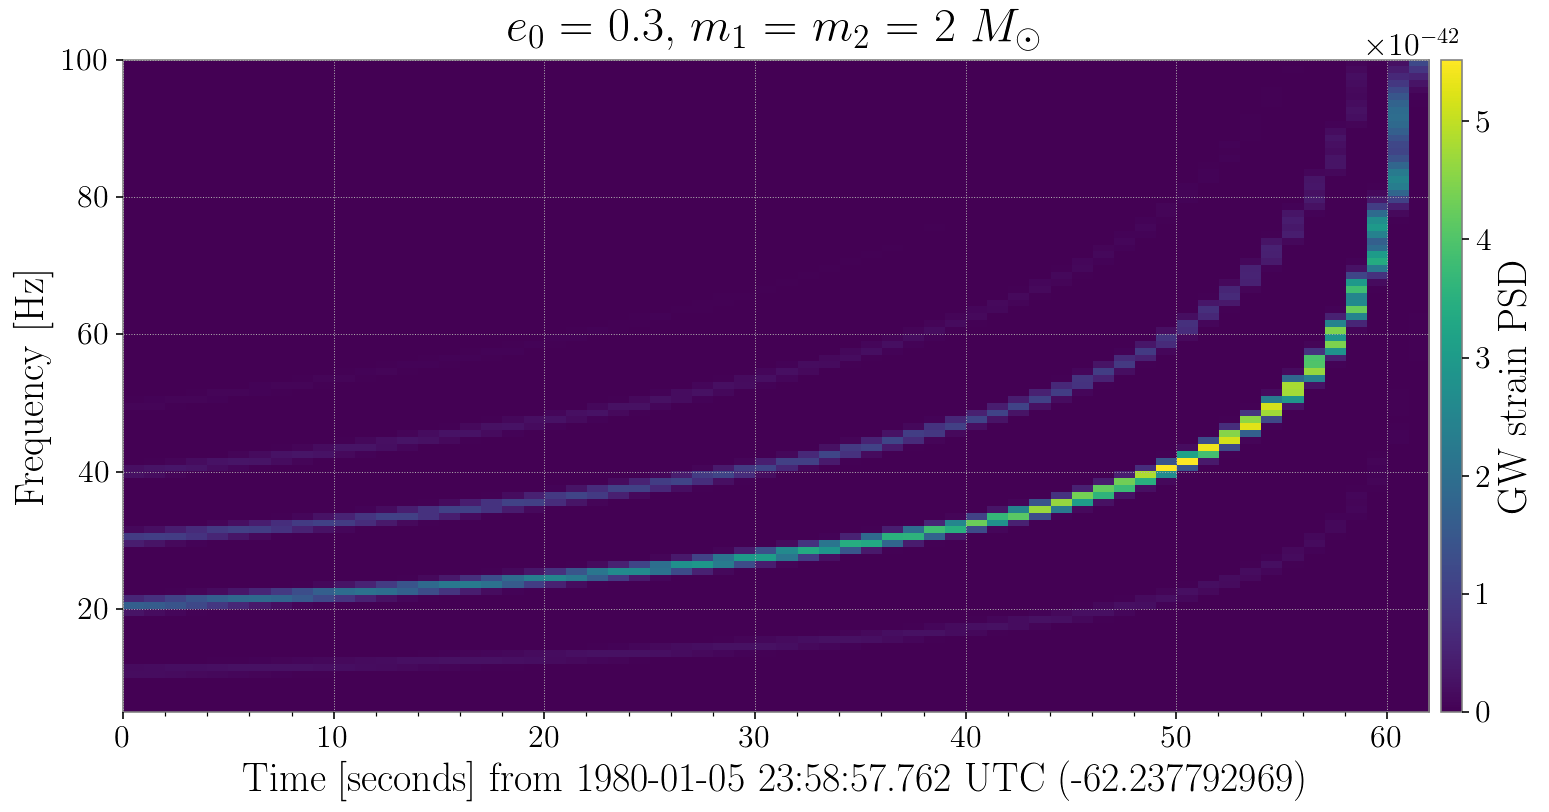

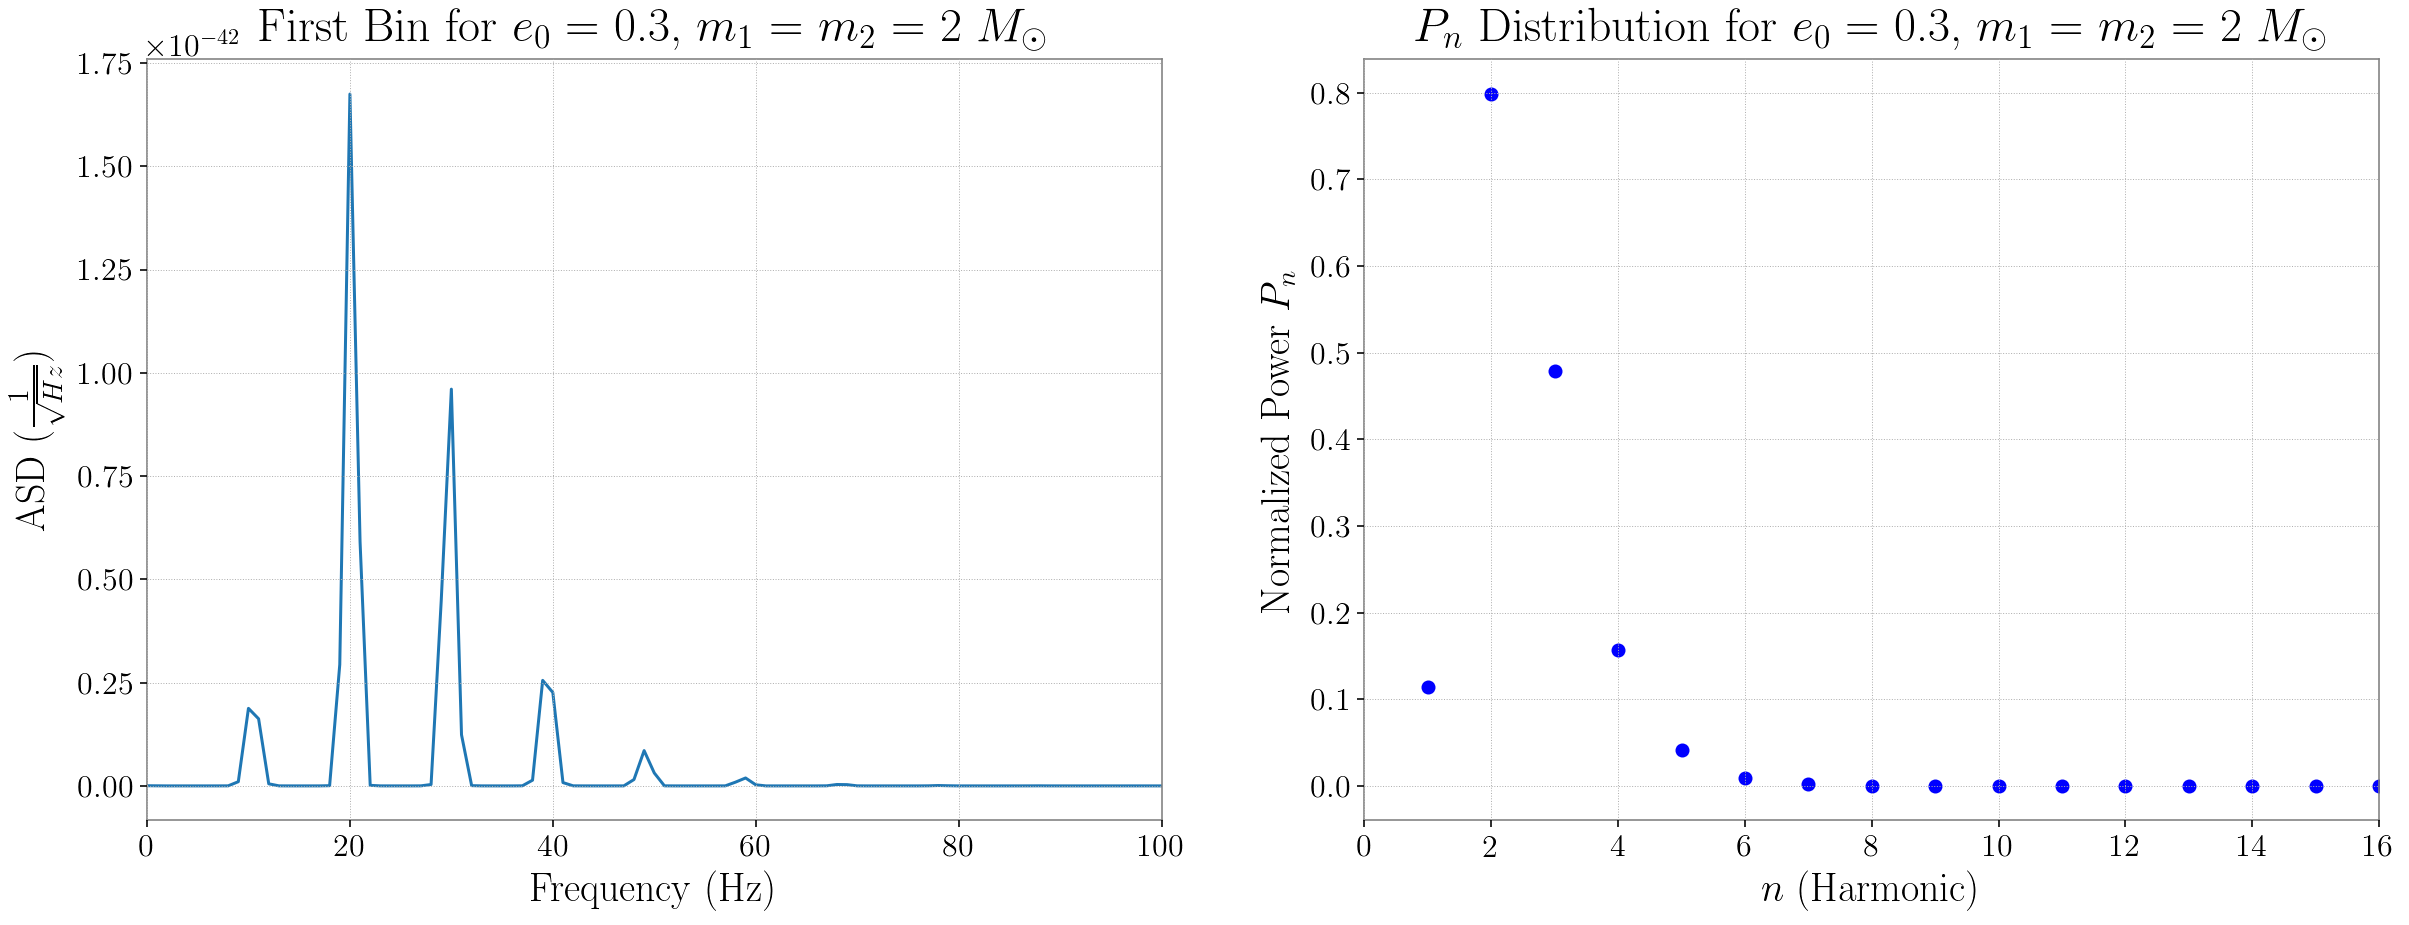

In [9]:
# define variables
e2 = 0.3
m1 = 2
m2 = 2
fftlen = 1

# generate plots!
genSpecAndPn(e2, m1, m2, fftlen)

In [10]:
# Different e0 values
e0 = 0.1
e1 = 0.2
e3 = 0.4
e4 = 0.5

norm: 3.20822269153e-42
max freqs: [10.0, 20.0, 30.0, 39.0, 49.0, 59.0, 68.0, 78.0, 88.0, 97.0, 106.0, 108.0, 1587.0, 1826.0, 1976.0, 1992.0, 1994.0, 2022.0, 2029.0, 2032.0, 2034.0, 2036.0, 2043.0, 2045.0]
min freqs: [2.0, 15.0, 25.0, 35.0, 46.0, 55.0, 65.0, 76.0, 86.0, 96.0, 105.0, 107.0, 1586.0, 1825.0, 1975.0, 1991.0, 1993.0, 2021.0, 2028.0, 2031.0, 2033.0, 2035.0, 2042.0, 2044.0]
Pn vals: [0.013817785009214295, 1.4144191897765275, 0.087086925079881014, 0.0031785614045204708, 9.471933630889329e-05, 2.5349993662288555e-06, 6.3493344274286211e-08, 1.523337271712453e-09, 3.6671580562677865e-11, 1.3622169670746146e-12, 9.0173192557811298e-14, 6.0744578705711758e-13, 8.8911651086694756e-20, 9.3386275552648791e-21, 1.9523204207534247e-22, 1.9007350449664911e-23, 1.6975632449096449e-22, 2.2038023512844323e-23, 7.8383161407172879e-24, 4.8136663004643769e-24, 4.5079695579955521e-24, 1.3959793549422088e-23, 3.6613013080377703e-24]


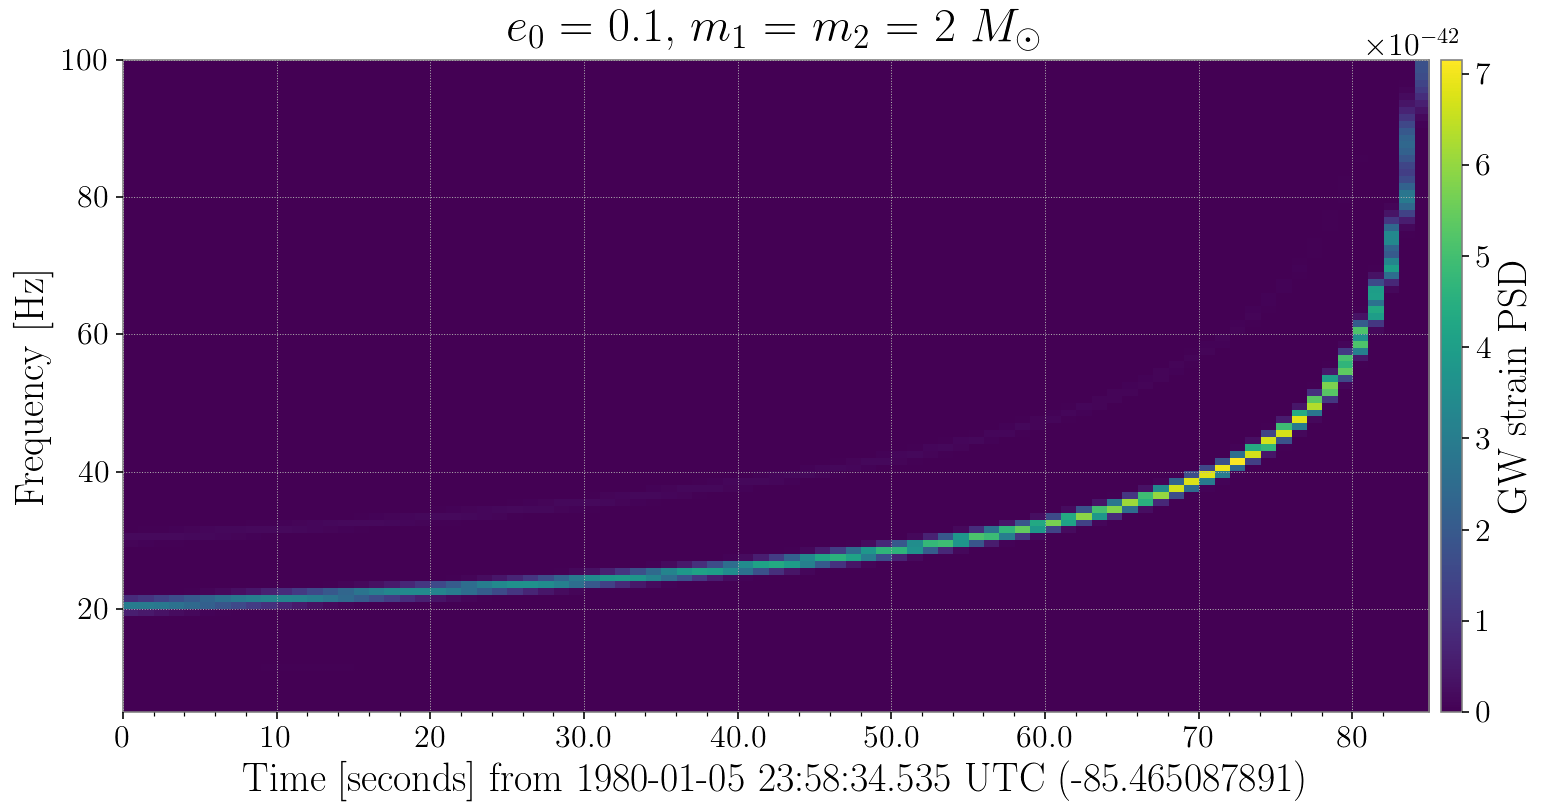

In [11]:
genSpecAndPn(e0, m1, m2, fftlen)

norm: 3.20822269153e-42
max freqs: [10.0, 20.0, 30.0, 39.0, 49.0, 59.0, 68.0, 78.0, 88.0, 97.0, 107.0, 112.0, 117.0, 126.0, 136.0, 145.0, 155.0, 158.0, 164.0, 166.0, 174.0, 177.0, 2036.0, 2043.0, 2045.0, 2047.0]
min freqs: [3.0, 15.0, 25.0, 35.0, 46.0, 54.0, 64.0, 75.0, 84.0, 94.0, 104.0, 111.0, 114.0, 124.0, 134.0, 144.0, 153.0, 157.0, 163.0, 165.0, 173.0, 176.0, 2035.0, 2042.0, 2044.0, 2046.0]
Pn vals: [0.053331581886412682, 1.1554650262530957, 0.29158137386558453, 0.042488318132922212, 0.0050218481380265622, 0.00053163097180969527, 5.25824667594967e-05, 4.9662047642963115e-06, 4.5363843112175432e-07, 4.0401354379173392e-08, 3.5275818883374876e-09, 1.0220464950939052e-13, 3.0339348398712565e-10, 2.5899408931504664e-11, 2.267570309020018e-12, 2.3948362055482209e-13, 3.3741563584228253e-14, 2.2150640520332161e-14, 7.0578103241906486e-15, 1.9985160804505581e-14, 5.9716288750099142e-15, 5.3439286328303752e-14, 2.4569533195274744e-23, 6.5374576537271977e-24, 6.4675391695561692e-24]


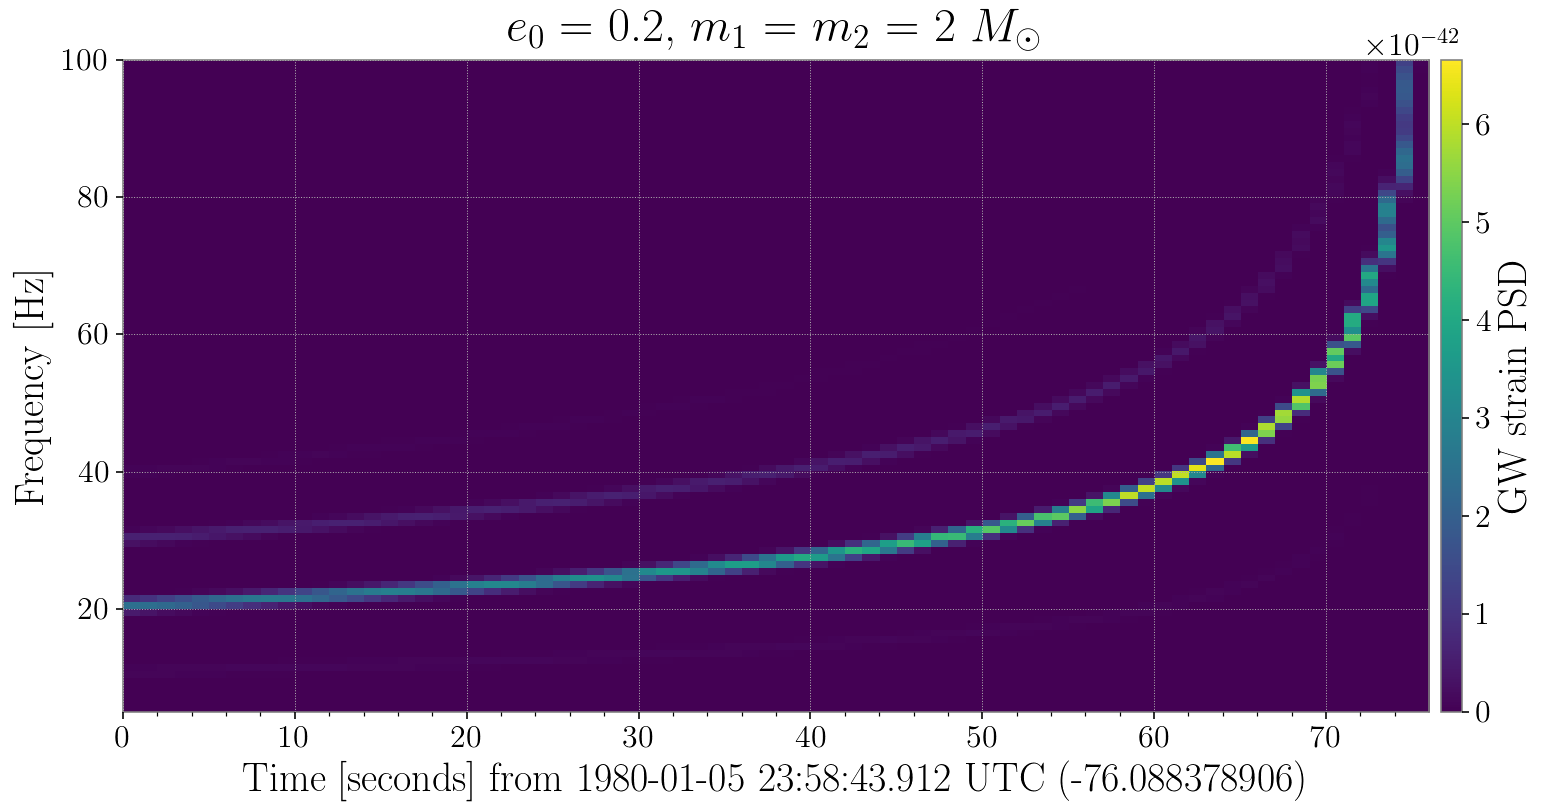

In [12]:
genSpecAndPn(e1, m1, m2, fftlen)

In [13]:
genSpecAndPn(e3, m1, m2, fftlen)

norm: 3.20822269153e-42
max freqs: [11.0, 20.0, 30.0, 40.0, 49.0, 59.0, 69.0, 78.0, 88.0, 98.0, 107.0, 117.0, 126.0, 136.0, 146.0, 155.0, 165.0, 175.0, 184.0, 194.0, 204.0, 213.0, 223.0, 233.0, 242.0, 252.0, 261.0, 271.0, 281.0, 290.0, 292.0, 295.0, 300.0, 308.0, 310.0, 315.0, 319.0, 321.0, 327.0, 329.0, 331.0, 334.0, 337.0, 340.0, 342.0, 346.0, 348.0, 351.0, 353.0, 356.0, 358.0, 362.0, 365.0, 368.0, 370.0, 375.0, 377.0, 379.0, 381.0, 387.0, 398.0, 406.0, 409.0, 2046.0]
min freqs: [3.0, 15.0, 25.0, 34.0, 45.0, 54.0, 64.0, 74.0, 83.0, 93.0, 103.0, 112.0, 122.0, 132.0, 141.0, 151.0, 160.0, 170.0, 180.0, 189.0, 199.0, 209.0, 219.0, 228.0, 238.0, 248.0, 258.0, 267.0, 277.0, 287.0, 291.0, 294.0, 296.0, 306.0, 309.0, 313.0, 316.0, 320.0, 325.0, 328.0, 330.0, 333.0, 335.0, 338.0, 341.0, 345.0, 347.0, 349.0, 352.0, 354.0, 357.0, 360.0, 364.0, 367.0, 369.0, 374.0, 376.0, 378.0, 380.0, 386.0, 397.0, 405.0, 408.0, 2045.0]
Pn vals: [0.18741657465080117, 0.43470969242441138, 0.52282695399208223, 0.

norm: 3.20822269153e-42
max freqs: [11.0, 20.0, 30.0, 40.0, 49.0, 59.0, 69.0, 78.0, 88.0, 98.0, 107.0, 117.0, 127.0, 136.0, 147.0, 155.0, 157.0, 165.0, 174.0, 176.0, 184.0, 186.0, 194.0, 196.0, 203.0, 205.0, 213.0, 215.0, 222.0, 225.0, 232.0, 235.0, 242.0, 244.0, 251.0, 254.0, 261.0, 264.0, 271.0, 274.0, 280.0, 283.0, 290.0, 293.0, 299.0, 303.0, 309.0, 312.0, 319.0, 322.0, 328.0, 332.0, 338.0, 342.0, 348.0, 351.0, 357.0, 361.0, 367.0, 371.0, 376.0, 381.0, 386.0, 390.0, 395.0, 400.0, 405.0, 410.0, 415.0, 419.0, 424.0, 426.0, 429.0, 434.0, 439.0, 443.0, 445.0, 448.0, 453.0, 456.0, 459.0, 462.0, 464.0, 467.0, 472.0, 474.0, 478.0, 481.0, 483.0, 485.0, 487.0, 491.0, 493.0, 496.0, 500.0, 504.0, 507.0, 510.0, 512.0, 515.0, 520.0, 522.0, 526.0, 529.0, 531.0, 533.0, 536.0, 539.0, 541.0, 544.0, 548.0, 550.0, 552.0, 554.0, 558.0, 560.0, 563.0, 567.0, 570.0, 573.0, 577.0, 579.0, 581.0, 586.0, 589.0, 592.0, 596.0, 598.0, 600.0, 608.0, 610.0, 615.0, 627.0, 2042.0, 2044.0]
min freqs: [3.0, 16.0, 25.0

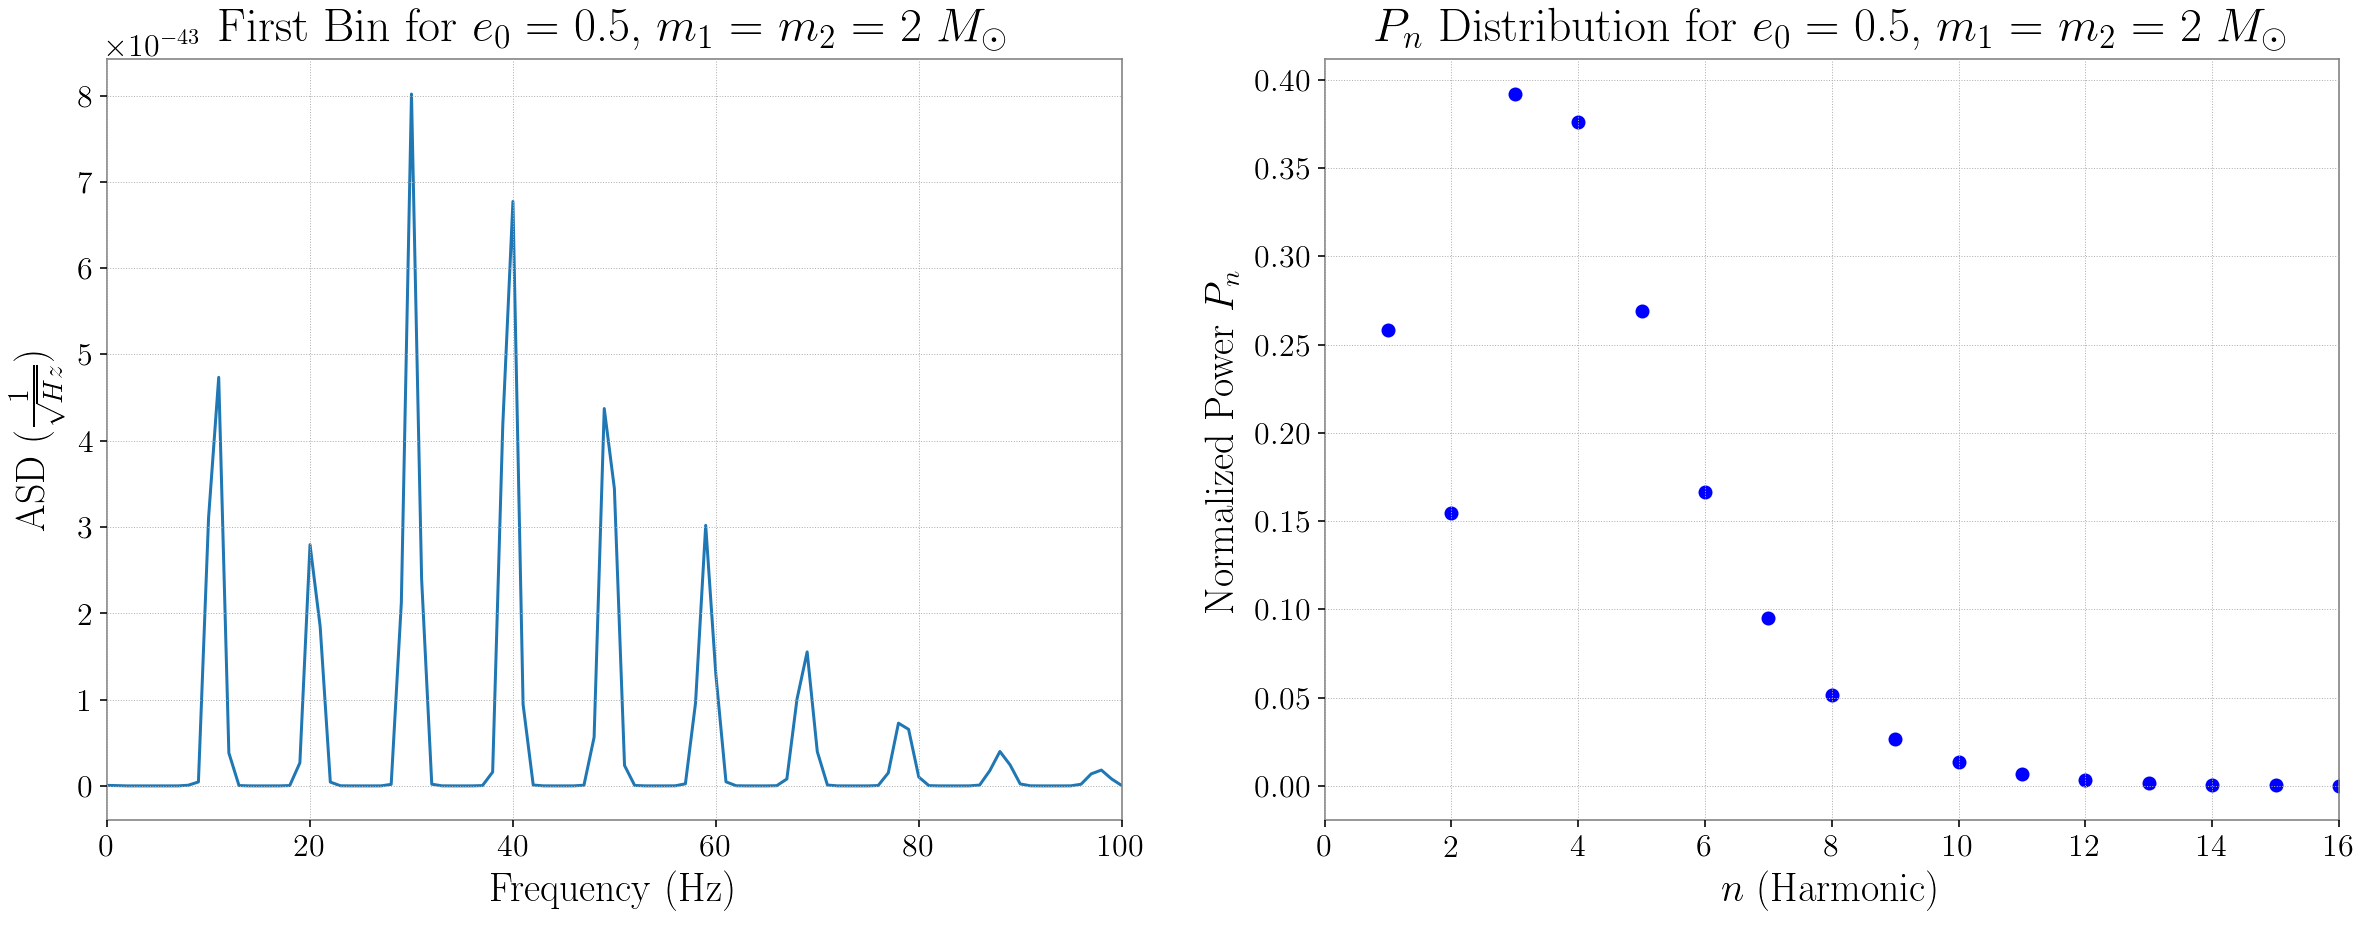

In [14]:
genSpecAndPn(e4, m1, m2, fftlen)

norm: 3.20822269153e-42
max freqs: [10.0, 20.0, 30.0, 39.0, 49.0, 1323.0, 1325.0, 1352.0, 1376.0, 1404.0, 1417.0, 1450.0, 1455.0, 1457.0, 1459.0, 1463.0, 1467.0, 1474.0, 1482.0, 1489.0, 1491.0, 1508.0, 1517.0, 1523.0, 1528.0, 1530.0, 1538.0, 1559.0, 1561.0, 1567.0, 1569.0, 1576.0, 1583.0, 1589.0, 1598.0, 1600.0, 1602.0, 1604.0, 1614.0, 1617.0, 1628.0, 1632.0, 1643.0, 1645.0, 1648.0, 1656.0, 1663.0, 1690.0, 1699.0, 1706.0, 1709.0, 1711.0, 1713.0, 1716.0, 1720.0, 1724.0, 1726.0, 1730.0, 1733.0, 1735.0, 1742.0, 1744.0, 1748.0, 1752.0, 1755.0, 1757.0, 1763.0, 1765.0, 1767.0, 1769.0, 1771.0, 1774.0, 1777.0, 1780.0, 1789.0, 1793.0, 1796.0, 1799.0, 1804.0, 1806.0, 1808.0, 1810.0, 1815.0, 1835.0, 1838.0, 1840.0, 1842.0, 1844.0, 1852.0, 1856.0, 1862.0, 1864.0, 1869.0, 1874.0, 1877.0, 1883.0, 1885.0, 1889.0, 1891.0, 1893.0, 1895.0, 1897.0, 1900.0, 1905.0, 1907.0, 1910.0, 1916.0, 1919.0, 1921.0, 1923.0, 1927.0, 1930.0, 1932.0, 1934.0, 1939.0, 1941.0, 1947.0, 1949.0, 1951.0, 1955.0, 1957.0, 1960.0

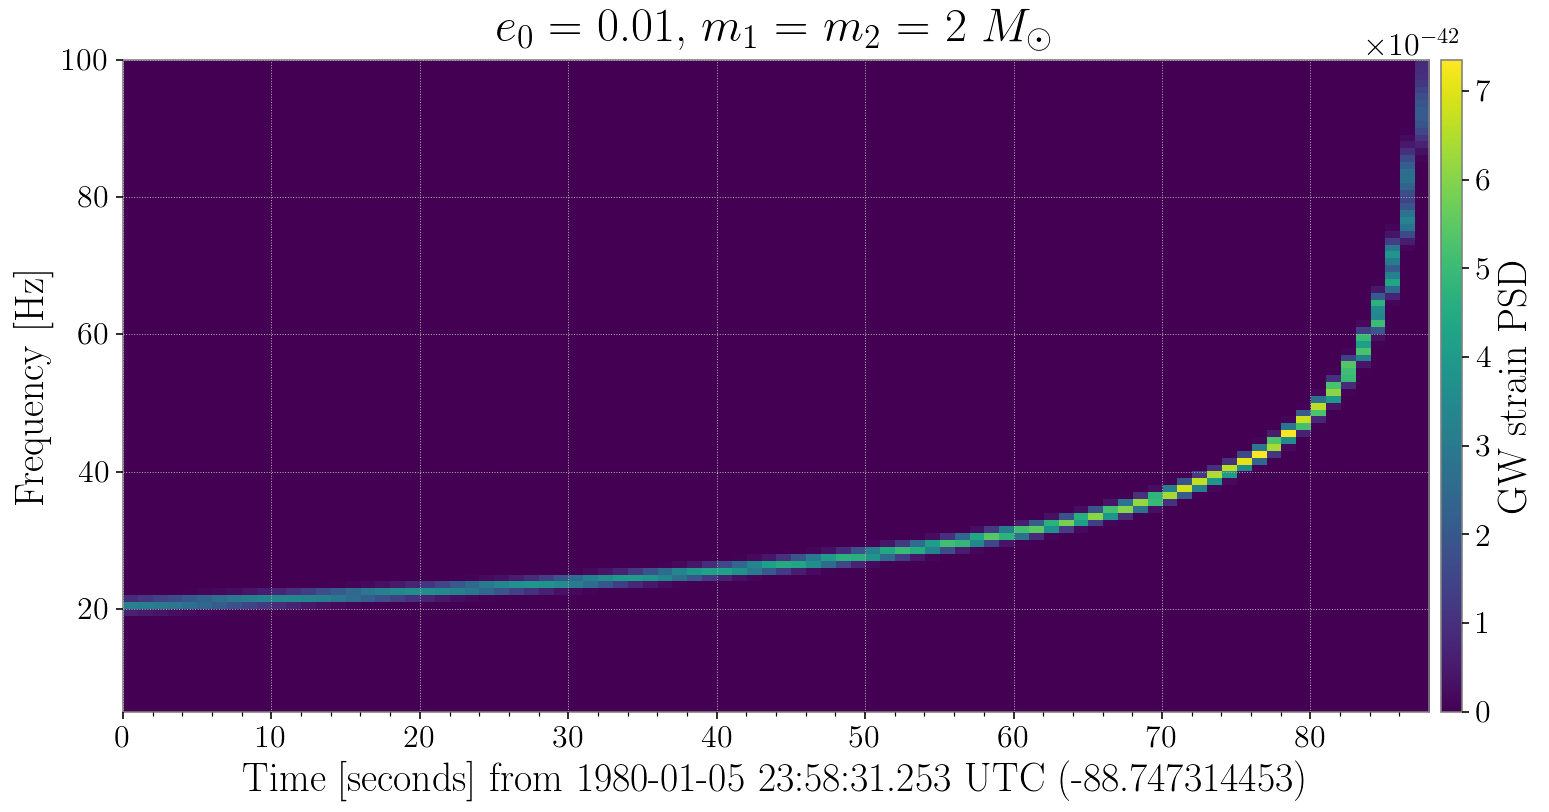

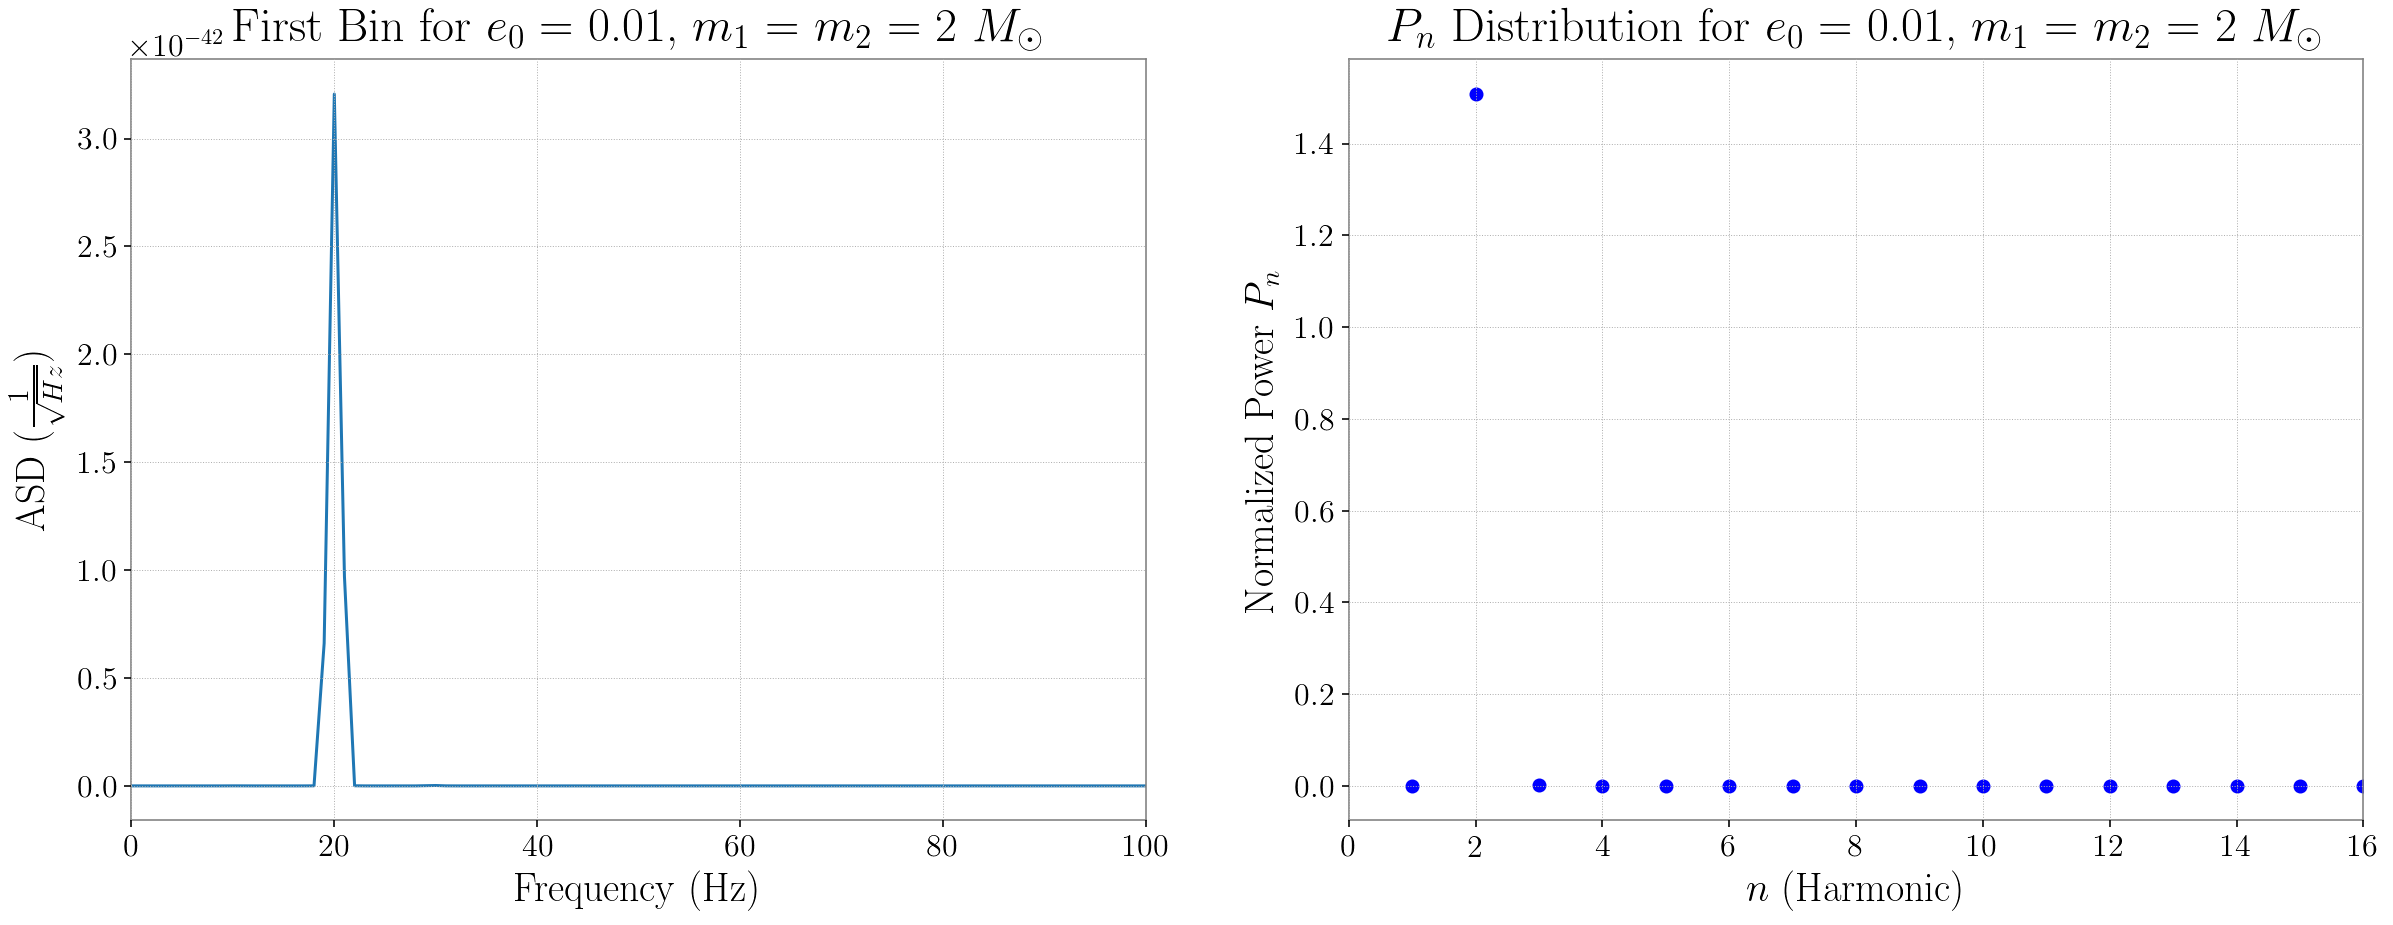

In [15]:
# Lower eccentricities
genSpecAndPn(0.01, m1, m2, fftlen)

In [16]:
genSpecAndPn(0.05, m1, m2, fftlen)

norm: 3.20822269153e-42
max freqs: [10.0, 20.0, 30.0, 39.0, 49.0, 54.0, 59.0, 68.0, 78.0, 80.0, 89.0, 1644.0, 1704.0, 1706.0, 1735.0, 1772.0, 1822.0, 1843.0, 1867.0, 1872.0, 1874.0, 1887.0, 1910.0, 1915.0, 1920.0, 1953.0, 1958.0, 1960.0, 1967.0, 1971.0, 1974.0, 1976.0, 1981.0, 1990.0, 1996.0, 2007.0, 2010.0, 2022.0, 2030.0, 2032.0, 2034.0, 2036.0, 2038.0, 2041.0, 2044.0, 2046.0]
min freqs: [2.0, 14.0, 25.0, 36.0, 46.0, 53.0, 56.0, 66.0, 77.0, 79.0, 88.0, 1643.0, 1703.0, 1705.0, 1734.0, 1771.0, 1821.0, 1842.0, 1866.0, 1871.0, 1873.0, 1886.0, 1909.0, 1914.0, 1919.0, 1952.0, 1957.0, 1959.0, 1966.0, 1970.0, 1973.0, 1975.0, 1980.0, 1989.0, 1995.0, 2006.0, 2009.0, 2021.0, 2029.0, 2031.0, 2033.0, 2035.0, 2037.0, 2040.0, 2043.0, 2045.0]
Pn vals: [0.0034823589309716232, 1.4849342653390931, 0.022736366968703691, 0.00020760504959493024, 1.5505367544900081e-06, 1.7366434459971797e-11, 1.0428239466908872e-08, 7.1479236474443212e-11, 9.6670822466842539e-13, 1.1225972982153287e-12, 1.1017597160579742

norm: 3.20822269153e-42
max freqs: [20.0, 1605.0, 1630.0, 1673.0, 1712.0, 1726.0, 1736.0, 1792.0, 1798.0, 1810.0, 1852.0, 1854.0, 1866.0, 1886.0, 1911.0, 1926.0, 1928.0, 1991.0, 2028.0, 2040.0, 2042.0, 2047.0]
min freqs: [2.0, 1604.0, 1629.0, 1672.0, 1711.0, 1725.0, 1735.0, 1791.0, 1797.0, 1809.0, 1851.0, 1853.0, 1865.0, 1885.0, 1910.0, 1925.0, 1927.0, 1990.0, 2027.0, 2039.0, 2041.0, 2046.0]
Pn vals: [1.5089696314727539, 9.2891576654698344e-21, 1.2974324344694968e-20, 9.0037323773267893e-21, 2.6864932600865876e-21, 1.7594122825488462e-21, 7.7121727048537442e-21, 6.3622997105069614e-22, 1.1762246646098355e-21, 3.2120620549286204e-21, 1.2167242964743066e-22, 6.755520696073192e-22, 9.3723659253867345e-22, 8.8039724267509031e-22, 3.9427275340069387e-22, 4.6109257164389746e-23, 8.1242741023126206e-22, 1.0415056650935778e-22, 7.8276087400045439e-24, 7.8445189397675056e-25, 1.5934177455412189e-24]


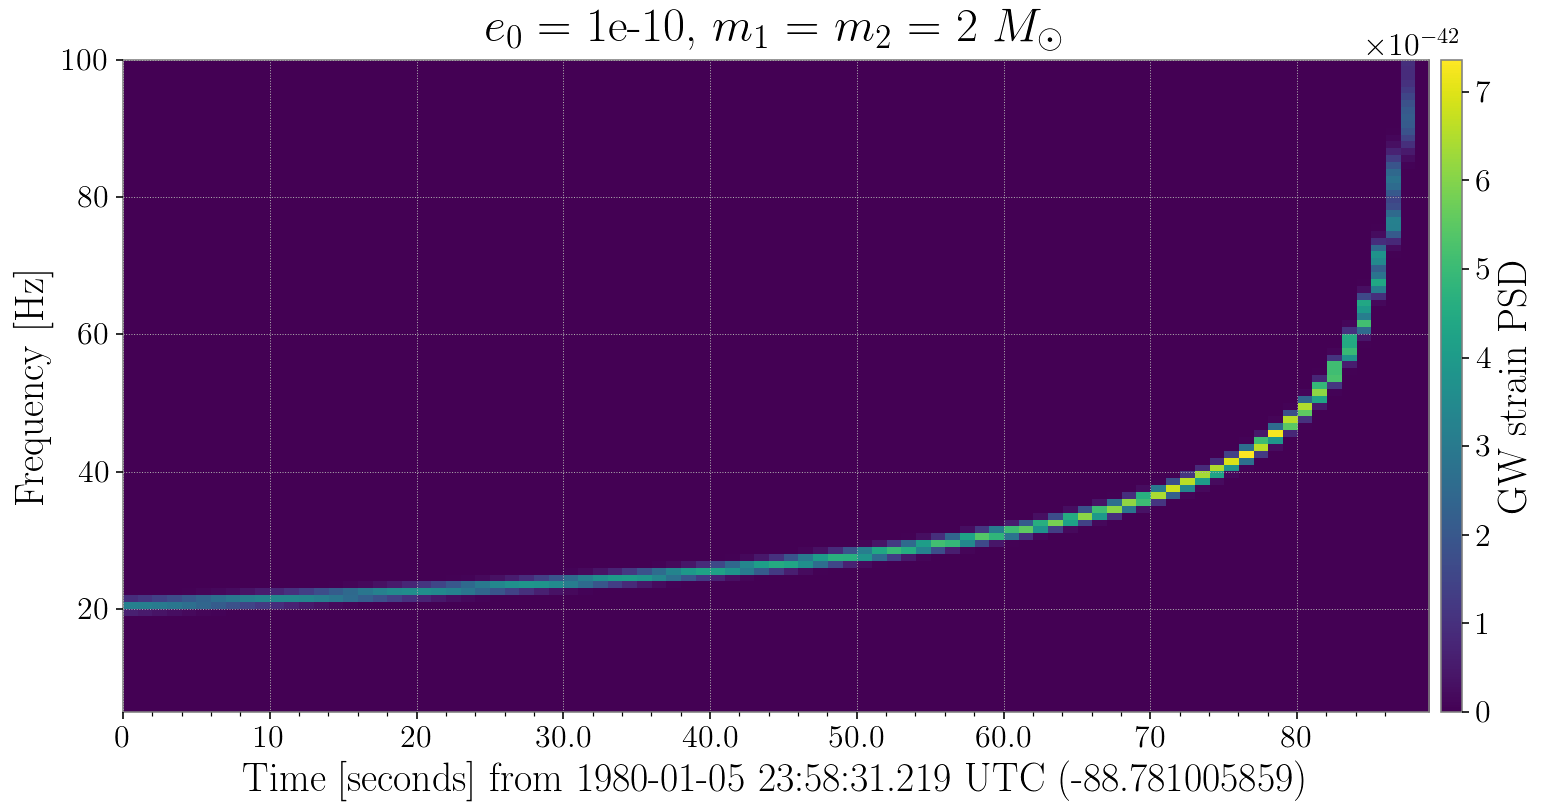

In [17]:
genSpecAndPn(1e-10, m1, m2, fftlen)

## Comparing Pn to PSD

In [18]:
from pycbc import psd as pypsd

# Generate PSD
seglen = 10
sample_rate = 2048
N = seglen*sample_rate/2+1
fmin = 20.
psd = np.sqrt(pypsd.analytical.aLIGODesignSensitivityP1200087(N, 1./seglen, 20.))*1000

# Generate Spectrogram
spec = genSpectrogram(e0, m1, m2, fftlen) # e0=0.3
asdbin1 = spec[0]
freqs = spec.frequencies 

In [19]:
plt.plot(freqs, asdbin1)
plt.plot(psd)
#plt.xlim(0,100)